In [34]:
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score

sns.set_theme()
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Load

In [2]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [3]:
X_train.head()

,trip_distance,passenger_count,pickup_hour_of_day,pickup_day_of_year,pickup_on_Monday,pickup_on_Tuesday,pickup_on_Wednesday,pickup_on_Thursday,pickup_on_Friday,pickup_on_Saturday,pickup_on_Sunday,pickup_near_airport_False,pickup_near_airport_True,dropoff_near_airport_False,dropoff_near_airport_True
0,2.832762,-0.505698,-0.716150,0.455003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,-0.145330,0.254749,0.995050,-0.863832,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.666403,-0.505698,-2.116223,0.028321,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.501012,-0.505698,0.061668,-0.456545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.501551,-0.505698,-0.871714,-0.378966,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [4]:
y_test.head()

,trip_duration
0,6.177944
1,5.068904
2,5.783825
3,5.187386
4,5.676754


# Model Training and Evaluation

## 01 - Linear model
1. Use DummyRegressor as a baseline model to predict trip duration.

In [5]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

y_pred = dummy_model.predict(X_test)

print(f"Dummy Regressor RMSE: {root_mean_squared_error(y_test, y_pred)}")

Dummy Regressor RMSE: 0.7008139096387153


2. Use LinearRegression, Ridge, and Lasso Regression from sklearn with Mean Squared Error (MSE) metric to evaluate performance on the test set.

In [6]:
linear_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

for name, model in linear_models.items():
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    mse = -scores.mean()
    print(f"{name} model MSE: {mse:.4f}")

Linear Regression model MSE: 0.2887
Ridge model MSE: 0.2887
Lasso model MSE: 0.4933


3. Calculate feature importance for features

----{Linear Regression Feature Importance}----
trip_distance                 0.500734
pickup_near_airport_False     0.235478
dropoff_near_airport_False    0.229145
pickup_on_Thursday            0.064368
pickup_on_Wednesday           0.055746
pickup_on_Friday              0.042918
pickup_on_Tuesday             0.036737
pickup_hour_of_day            0.035337
pickup_day_of_year            0.028215
passenger_count               0.006864
pickup_on_Saturday           -0.035819
pickup_on_Monday             -0.048847
pickup_on_Sunday             -0.115104
dropoff_near_airport_True    -0.229145
pickup_near_airport_True     -0.235478
dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

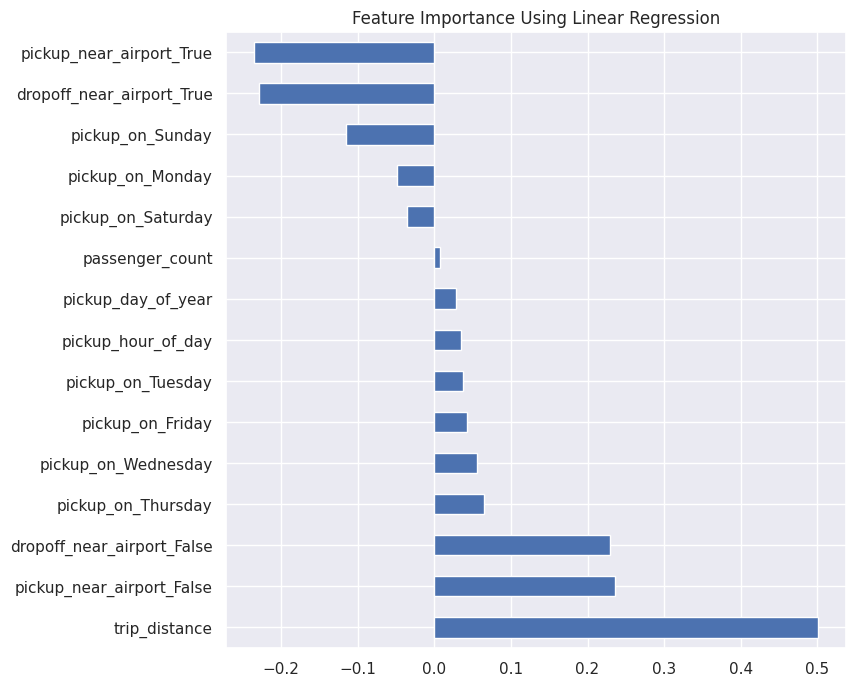

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)

selected_features = pd.Series(lr.coef_.flatten(), index=X_train.columns).sort_values(ascending=False)

print("----{Linear Regression Feature Importance}----")
print(selected_features)

plt.rcParams['figure.figsize'] = (8.0, 8.0)
selected_features.plot(kind='barh')
plt.title("Feature Importance Using Linear Regression")
plt.show

In [21]:
final_features = [
    'trip_distance',
    'pickup_on_Thursday',
    'pickup_on_Wednesday',
    'pickup_on_Monday',
    'pickup_on_Sunday',
    'pickup_on_Saturday',
    'dropoff_near_airport_True',
    'pickup_near_airport_True',
    'pickup_hour_of_day'
]

In [22]:
for name, model in linear_models.items():
    scores = cross_val_score(model, X_train[final_features], y_train, scoring='neg_mean_squared_error', cv=10)
    mse = -scores.mean()
    print(f"{name} model MSE: {mse:.4f}")

Linear Regression model MSE: 0.2896
Ridge model MSE: 0.2896
Lasso model MSE: 0.4933


4. Use Lasso regression for feature selection.

In [23]:
lasso = Lasso(alpha=1e-4)
lasso.fit(X_train[final_features], y_train)

selected_features = pd.Series(lasso.coef_, index=X_train[final_features].columns).sort_values(ascending=False)

print("----{Lasso Regression Feature Importance}----")
print(selected_features)

----{Lasso Regression Feature Importance}----
trip_distance                0.499923
pickup_hour_of_day           0.035217
pickup_on_Thursday           0.026064
pickup_on_Wednesday          0.016948
pickup_on_Saturday          -0.073873
pickup_on_Monday            -0.086999
pickup_on_Sunday            -0.153072
dropoff_near_airport_True   -0.447986
pickup_near_airport_True    -0.465964
dtype: float64


1. Tune Hyperparameters using GridSearchCV.

In [ ]:
param_grid = {'alpha': np.logspace(-2, 3, 10)}
grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train[final_features], y_train)

print(f"Best parameters for Ridge: {grid.best_params_['alpha']:.3f}")
print(f"Best MSE: {-grid.best_score_:.4f}")

Best parameters for Ridge: 278.256
Best MSE: 0.2899


In [26]:
X_train = X_train[final_features]
X_test = X_test[final_features]

## 02 - DecisionTreeRegressor
1. Use DecisionTreeRegressor with Mean Squared Error (MSE) metric to evaluate performance on the test set

In [28]:
%%time

dtr = DecisionTreeRegressor(random_state=14)
dtr.fit(X_train, y_train)

mse = mean_squared_error(y_test, dtr.predict(X_test))
print(f"Decision Tree Regressor MSE: {mse:.4f}")

Decision Tree Regressor MSE: 0.3113
CPU times: user 7.54 s, sys: 60 ms, total: 7.6 s
Wall time: 7.68 s


1. Tune Hyperparameters using GridSearchCV.

In [32]:
%%time
param_grid = {
    'max_depth': [5, 10],
    'min_samples_leaf': [2, 6],
    'max_features': [1.0, 'sqrt', 'log2']
}

grid_dtr = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_dtr.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_dtr.best_params_)
print(f"Best MSE: {-grid_dtr.best_score_:.4f}")

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 6}
Best MSE: 0.1580
CPU times: user 1min 18s, sys: 727 ms, total: 1min 19s
Wall time: 1min 19s


3. Calculate feature importance for features

In [ ]:
best_dtr = grid_dtr.best_estimator_
importance_values = best_dtr.feature_importances_

selected_features = pd.Series(importance_values, index=X_train.columns).sort_values(ascending=False)
print("----{Feature Importance for Tuned Decision Tree}----")
print(selected_features)

----{Feature Importance for Tuned Decision Tree}----
trip_distance                0.910919
pickup_hour_of_day           0.063841
pickup_on_Sunday             0.012409
pickup_on_Saturday           0.008513
pickup_on_Monday             0.003503
pickup_near_airport_True     0.000624
dropoff_near_airport_True    0.000091
pickup_on_Wednesday          0.000065
pickup_on_Thursday           0.000035
dtype: float64


## 03 - Random Forest

In [35]:
rf = RandomForestRegressor(n_estimators=50, random_state=14, max_features=3)
rf.fit(X_train, y_train)

mse = mean_squared_error(y_test, rf.predict(X_test))

print(f"Random Forest MSE: {mse:.4}")

/run/media/os14you/DataHub/projects/ny-taxi-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest MSE: 0.2285


2. Tune Hyperparameters using GridSearchCV.

In [36]:
%%time
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_leaf': [2, 4]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state = 14), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)
print(f"Best MSE: {-grid_rf.best_score_:.4f}")

/run/media/os14you/DataHub/projects/ny-taxi-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/run/media/os14you/DataHub/projects/ny-taxi-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/run/media/os14you/DataHub/projects/ny-taxi-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/run/media/os14you/DataHub/projects/ny-taxi-prediction/

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
Best MSE: 0.1564
CPU times: user 1h 8min 54s, sys: 3.41 s, total: 1h 8min 58s
Wall time: 1h 10min 59s


In [37]:
best_rf = grid_rf.best_estimator_
importances = best_rf.feature_importances_

selected_features = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print("----{Feature Importance for Tuned Decision Tree}----")
print(selected_features)

----{Feature Importance for Tuned Decision Tree}----
trip_distance                0.910729
pickup_hour_of_day           0.063796
pickup_on_Sunday             0.012440
pickup_on_Saturday           0.008636
pickup_on_Monday             0.003446
pickup_near_airport_True     0.000611
dropoff_near_airport_True    0.000153
pickup_on_Wednesday          0.000112
pickup_on_Thursday           0.000077
dtype: float64


# Conclusion

In [38]:
dtr = DecisionTreeRegressor(**grid_dtr.best_params_)
dtr.fit(X_train, y_train)
mse = mean_squared_error(y_test, dtr.predict(X_test))

print(f"Decision Tree MSE: {mse:.4f}")

Decision Tree MSE: 0.1695


In [39]:
scores = cross_val_score(best_dtr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
mse = -scores.mean()
tmse = mean_squared_error(y_test, best_dtr.predict(X_test))

print(f"Decision Tree MSE with selected features: {mse:.4f}")
print(f"Decision Tree MSE on Test: {tmse:.4f}")

Decision Tree MSE with selected features: 0.1580
Decision Tree MSE on Test: 0.1695


In [40]:
rf = RandomForestRegressor(**grid_rf.best_params_)
rf.fit(X_train, y_train)

mse = mean_squared_error(y_test, rf.predict(X_test))

print(f"Random Forest MSE: {mse:.4f}")

/run/media/os14you/DataHub/projects/ny-taxi-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest MSE: 0.1680


In [41]:
scores = cross_val_score(best_rf, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
mse = -scores.mean()
tmse = mean_squared_error(y_test, best_rf.predict(X_test))

print(f"Decision Tree MSE with selected features: {mse:.4f}")
print(f"Decision Tree MSE on Test: {tmse:.4f}")

/run/media/os14you/DataHub/projects/ny-taxi-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/run/media/os14you/DataHub/projects/ny-taxi-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/run/media/os14you/DataHub/projects/ny-taxi-prediction/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/run/media/os14you/DataHub/projects/ny-taxi-prediction/

Decision Tree MSE with selected features: 0.1564
Decision Tree MSE on Test: 0.1681


- **Linear Regression MSE with selected features: $0.2896$**
- **Ridge MSE with selected features: $0.2896$**
- **Lasso MSE with selected features: $0.4933$**
- **Decision Tree MSE: $0.1695$**
- **Random Forest MSE: $0.1681$**

**I'll choose the Decision Tree instead of the Random Forest. While the Random Forest offers the best performance, its training time is significantly longer, and it is more prone to overfitting in the long run**